# 1. Business Understanding

### a- Introduction

The motivation for this project is to provide a more informed and data-driven approach to stock trading, which can potentially lead to higher profits and better investment decisions, and a trading bot that uses machine learning to predict optimal times to buy and sell Tencent stock. We chose to use Tencent's historical stock movement (0700.HK) data due to its consistent growth and stability, making it a reliable investment option.

### b- Project description

This potential project aims to develop a trading mechanism that can predict the high and low stocks of Tencent (0700.HK). We will then clean and preprocess the data then the argrelextrema method from the scipy.signal package, which locates local maximum and minimum values, will be used to extract and annotate the dataset. The machine learning model used will be a classification model with three classes: high, low, and neither. 

### c- Training and validation

The model will be trained and validated using the Tencent (0700.HK) dataset, training will be on data from 2015-2018, and validation data will from 2019-2020, we will use accuracy score to evaluate the model's performance.

### d- Trading bot

The final trading system will aim to maximize profit and have three parameters: g, l, and d. By altering these factors, the project will produce four distinct investor types: Short-term Investor, Medium-term Investor, Long-term Holder, and Random Investor. The smallest value of l will be held by the short-term investor, the middle-term investor will hold both l and g at an intermediate value, the long-term holder will hold the biggest value of g, and the random investor will hold g, l, and d at random values. 
The real business delivery will be applied on the testing data which is data from 2021.

#  2.  Data retrieving and processing

In [1]:
import yfinance as yf

# Retrieve data from Yahoo Finance
dataset = yf.download('0700.HK', start='2015-01-01', end='2021-12-31')

[*********************100%***********************]  1 of 1 completed


In [2]:
dataset.shape

(1727, 6)

The dataset has 6 features & 1727 samples

In [3]:
dataset.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,113.599998,113.599998,111.300003,112.800003,110.276039,10862542
2015-01-05,113.500000,115.300003,112.800003,113.500000,110.960365,21808993
2015-01-06,114.000000,120.500000,113.599998,120.000000,117.314934,43678255


In [4]:
dataset.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-28,457.799988,459.200012,445.000000,450.399994,448.291626,18949609
2021-12-29,443.600006,445.600006,440.399994,444.799988,442.717834,9589399
2021-12-30,446.399994,450.799988,442.000000,443.399994,441.324402,7664650


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1727 entries, 2015-01-02 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1727 non-null   float64
 1   High       1727 non-null   float64
 2   Low        1727 non-null   float64
 3   Close      1727 non-null   float64
 4   Adj Close  1727 non-null   float64
 5   Volume     1727 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 94.4 KB


There are no missing values, so far there will be no preprocessing needed.

### Retrieve data

In [6]:
import pandas as pd
import yfinance as yf
from scipy.signal import argrelextrema
import numpy as np


# Find local maxima and minima
local_max = argrelextrema(dataset['Close'].values, comparator=np.greater, order=10)[0]
local_min = argrelextrema(dataset['Close'].values, comparator=np.less, order=10)[0]

# Combine maxima and minima indices and sort them
extrema = np.sort(np.concatenate([local_max, local_min]))

# Create a new column for the labels, initialize all values to 0
dataset['Label'] = 0

# Label the data as high, low, or neither
for i in range(1, len(extrema)):
    if dataset['Close'][extrema[i]] > dataset['Close'][extrema[i-1]]:
        dataset.loc[(dataset.index >= dataset.index[extrema[i-1]]) & (dataset.index <= dataset.index[extrema[i]]), 'Label'] = 1
    elif dataset['Close'][extrema[i]] < dataset['Close'][extrema[i-1]]:
        dataset.loc[(dataset.index >= dataset.index[extrema[i-1]]) & (dataset.index <= dataset.index[extrema[i]]), 'Label'] = 2


In [7]:
dataset['Label'].value_counts()

1    986
2    718
0     23
Name: Label, dtype: int64

0 refers to neither local high nor low price.
1 refers to local high price.
2 refers to local low price.

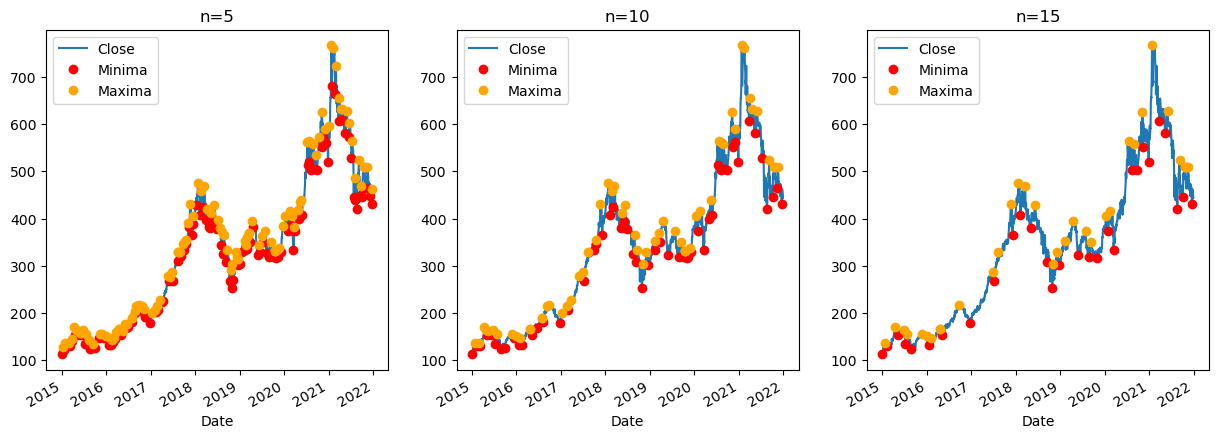

In [12]:
from scipy.signal import argrelextrema 
from matplotlib import pyplot as plt 
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, n in enumerate([5, 10, 15]):
    ax = dataset['Close'].plot(ax=axs[i]) 
    ax = dataset.iloc[argrelextrema(dataset.Close.values, np.less_equal, 
        order=n)]['Close'].plot(ax=axs[i], style="o", color='red') 
    ax = dataset.iloc[argrelextrema(dataset.Close.values, 
        np.greater_equal, order=n)]['Close'].plot(ax=axs[i], style="o", color='orange') 
    axs[i].set_title(f"n={n}")
    axs[i].legend(["Close", "Minima", "Maxima"])

plt.show()

This figures show the difference between the local values found with order = 5, 10 and 15. The order means how many data points (days) to be considered when finding the extrema.

# 3. Feature selection 

In [111]:
# Compute Simple Moving Average (SMA)
def sma(data, window):
    return data.rolling(window=window).mean()

# Compute Exponential Moving Average (EMA)
def ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

# Compute Relative Strength Index (RSI)
def rsi(data, window):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = ema(up, window)
    ema_down = ema(down, window)
    rs = ema_up/ema_down
    return 100 - (100/(1+rs))

# Compute Bollinger Bands
def bollinger_bands(data, window, num_std):
    rolling_mean = sma(data, window)
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band
# Compute MACD
def calculate_macd(prices, slow=26, fast=12, signal=9):
    ema_slow = prices.ewm(span=slow).mean()
    ema_fast = prices.ewm(span=fast).mean()
    macd = ema_fast - ema_slow
    return macd

dataset['SMA_20'] = sma(dataset['Close'], window=20)
dataset['EMA_20'] = ema(dataset['Close'], window=20)
dataset['RSI_14'] = rsi(dataset['Close'], window=14)
dataset['Bollinger_upper'], dataset['Bollinger_lower'] = bollinger_bands(dataset['Close'], window=20, num_std=2)
dataset['MACD'] =  calculate_macd(dataset['Close'])

Technical analysis indicators choice:

*SMA and EMA: These indicators provide insight into the trend of the stock price over a given time period. By analyzing the movement of the stock price relative to the SMA and EMA, we can determine whether the price is in an uptrend or downtrend.

*RSI: This indicator is used to identify whether a stock is overbought or oversold. It compares the average gains of the stock over a given time period to the average losses and gives a value between 0 and 100. A value above 70 is generally considered overbought, while a value below 30 is considered oversold.

*Bollinger Bands: These are used to measure the volatility of the stock price. They consist of three lines: the upper band, the lower band, and the middle band (which is typically the 20-day moving average). When the stock price moves outside of the upper or lower band, it is considered to be overbought or oversold, respectively.

*MACD: This indicator combines two moving averages to generate trading signals. When the shorter-term moving average crosses above the longer-term moving average, it generates a bullish signal, indicating that the stock price may go up.

In [94]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1727 entries, 2015-01-02 to 2021-12-30
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1727 non-null   float64
 1   High             1727 non-null   float64
 2   Low              1727 non-null   float64
 3   Close            1727 non-null   float64
 4   Adj Close        1727 non-null   float64
 5   Volume           1727 non-null   int64  
 6   Label            1727 non-null   int64  
 7   SMA_20           1708 non-null   float64
 8   EMA_20           1727 non-null   float64
 9   RSI_14           1726 non-null   float64
 10  Bollinger_upper  1708 non-null   float64
 11  Bollinger_lower  1708 non-null   float64
 12  MACD             1727 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 188.9 KB


In [112]:
# Dropping NaN and missing values
dataset = dataset.dropna()
dataset = dataset.fillna('')

In [113]:
dataset.head(3)

,Open,High,Low,Close,Adj Close,Volume,Label,SMA_20,EMA_20,RSI_14,Bollinger_upper,Bollinger_lower,MACD
Date,,,,,,,,,,,,,
2015-01-29,136.000000,136.399994,133.800003,134.600006,131.588242,14636100,2,126.975,127.693756,68.310714,140.625968,113.324033,2.266299
2015-01-30,135.500000,135.500000,129.500000,132.000000,129.046448,29375696,2,127.935,128.103875,57.080982,139.996644,115.873356,2.080870
2015-02-02,129.899994,136.800003,129.899994,135.800003,132.761398,17654028,2,129.050,128.836839,66.396761,139.509647,118.590354,2.167404


# 4. Modelling and evaluation

### a- Splitting data

In [14]:
# Split the data into training and validation sets (2015-2020) and a final testing set (2021)
train_data = dataset.loc['2015-01-01':'2018-12-31']
val_data = dataset.loc['2019-01-01':'2020-12-31']
test_data = dataset.loc['2021-01-01':]

In [15]:
X_train = train_data.drop(['Label','High', 'Low', 'Volume'], axis=1)
y_train = train_data['Label']

X_val = val_data.drop(['Label', 'High', 'Low', 'Volume'], axis=1)
y_val = val_data['Label']

### b- Normalizing data

In [16]:
from sklearn.preprocessing import MinMaxScaler

# create the scaler object and fit it on the training data
scaler = MinMaxScaler()
scaler.fit(X_train)

# normalize the training and validation data using the fitted scaler
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)

The previous step 'Normalizing data' will make sure the model trains fast in a more accurate way.

### c- Statistical repport

In [117]:
dataset['Label'].value_counts()

1    986
2    715
0      7
Name: Label, dtype: int64

In [118]:
X_train.shape, X_val.shape

((968, 9), (494, 9))

In [119]:
test_data['Label'].value_counts()

2    164
1     75
0      7
Name: Label, dtype: int64

1708 total samples
986 positive samples: local high price
715 negative samples: local low price
7 neutral samples: neither local high nor low price

For model training and validation, we are using 968 samples of data from 2015-2018 to train our machine learning model. The evaluation is then made on 494 samples of data from 2019-2020.
To test the model later on with the trading bot, 246 samples of data from 2021 will be used for that goal.

Evaluating the model will be done by calculating F1 using the f1_score from scikit learn library.

### d- Model training and evaluation

#####  *Testing differents model with the best potential to be trained accurately with the data

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

model_1 = RandomForestClassifier(n_estimators=500)
model_1.fit(X_train_norm, y_train)

y_pred = model_1.predict(X_val_norm)
f1 = f1_score(y_pred, y_val)

print('For the Random Forest model, F1 score on Validation data is: ',round(f1*100,2),'%')

For the Random Forest model, F1 score on Validation data is:  50.39 %


In [23]:
from sklearn.linear_model import LogisticRegression

model_2 = LogisticRegression()
model_2.fit(X_train_norm, y_train)

y_pred = model_2.predict(X_val_norm)
f1 = f1_score(y_pred, y_val)

print('For the Logistic Regression model, F1 score on Validation data is: ',round(f1*100,2),'%')

For the Logistic Regression model, F1 score on Validation data is:  62.36 %


In [24]:
from sklearn import svm

model_3 = svm.SVC(kernel='linear')
model_3.fit(X_train_norm, y_train)

y_pred = model_3.predict(X_val_norm)
f1 = f1_score(y_pred, y_val)

print('For the Support Vector Machine model, F1 score on Validation data is: ',round(f1*100,2),'%')

For the Support Vector Machine model, F1 score on Validation data is:  77.11 %


In [29]:
import xgboost as xgb

model_4 = xgb.XGBClassifier(objective='multi:softmax', num_class=3, seed=42)
model_4.fit(X_train_norm, y_train)

y_pred = model_4.predict(X_val_norm)
f1 = f1_score(y_pred, y_val)

print('For the XGBoost model, F1 score on Validation data is: ',round(f1*100,2),'%')

For the XGBoost model, F1 score on Validation data is:  50.59 %


In [30]:
from sklearn.naive_bayes import GaussianNB

model_5 = GaussianNB()
model_5.fit(X_train_norm, y_train)

y_pred = model_5.predict(X_val_norm)
f1 = f1_score(y_pred, y_val)

print('For the Naive Bayes model, F1 score on Validation data is: ',round(f1*100,2),'%')

For the Naive Bayes model, F1 score on Validation data is:  10.47 %


*By comparing this different model will can say that the model with the best performance is "Support Vector Machine" model, because they are well-suited for non-linear classification problems, which can be useful for predicting stock market movements that often exhibit non-linear behavior. Its also less prone to overfitting compared to other models, such as decision trees or neural networks. This is because SVMs try to maximize the margin between the classes, which effectively reduces the number of support vectors and leads to a more generalized model.

In [25]:
from sklearn import svm

model = svm.SVC(kernel='linear')
model.fit(X_train_norm, y_train)

SVC(kernel='linear')

In [26]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_val_norm)
f1 = f1_score(y_pred, y_val)

print('F1 score on Validation data is: ',round(f1*100,2),'%')

F1 score on Validation data is:  77.11 %


Predicting stock market trends is challenging due to the influence of many factors (economy, public sentiments, costumers bihavior, and political factors) which always change not just historical stock movement, so an f1 score between 60-80% is considered good. The Support Vector Machine model got a score=77.11% which indicate that the model is well trained.

# 5. Real business performance delivery 


In [123]:
# Define a function to generate buy and sell signals
def generate_signals(data, model):
    signals = model.predict(data)
    return signals

In [124]:
# Define a function to calculate profit
def calculate_profit(data, signals, g, l, d):
    shares = 0
    buy_price = 0
    profit = 0
    for i in range(len(data)):
        if signals[i] == 2:
            shares += 100
            buy_price = data[i][3] 
        elif signals[i] == 1:
            if shares > 0:
                sell_price = data[i][3] 
                if (sell_price - buy_price) / buy_price >= g or (sell_price - buy_price) / buy_price <= l or i == len(data)-1 or i == d:
                    profit += (sell_price - buy_price) * shares
                    shares = 0
        elif signals[i] == 0:
            if shares > 0 and (i == len(data)-1 or i == d):
                sell_price = data[i][3] 
                profit += (sell_price - buy_price) * shares
                shares = 0
    return profit

In [129]:
investor_types = {
    'Short-term Investor': {'g': 0.01, 'l': -0.01, 'd': 5},
    'Medium-term Investor': {'g': 0.03, 'l': -0.02, 'd': 15},
    'Long-term Holder': {'g': 0.05, 'l': -0.03, 'd': 30},
    'Random Investor': {'g': 0, 'l': -1, 'd': 4}
}
profits = {}
for investor_type in investor_types:
    g = investor_types[investor_type]['g']
    l = investor_types[investor_type]['l']
    d = investor_types[investor_type]['d']
    X_test = test_data.drop(['Label', 'High', 'Low', 'Volume'], axis=1)    
    X_test_norm = scaler.transform(X_test)
    signals = generate_signals(X_test_norm, model)
    profit = calculate_profit(X_test_norm, signals, g, l, d)
    profits[investor_type] = profit

In [130]:
for investor_type in profits:
    print(investor_type, 'profit:', profits[investor_type])


Short-term Investor profit: 232.64892216947808
Medium-term Investor profit: 615.1422448944113
Long-term Holder profit: 885.0400986987665
Random Investor profit: 86.26593118637724


From the results above we can say that the Long-term Holder Investor has the best trading strategy.
The reasons for its advantage are :

*Time in the market: he have more time to ride out short-term fluctuations in the stock market.

*Reduced trading costs: By holding onto investments for a long period of time, he can avoid frequent trading, which can result in lower transaction costs and capital gains taxes.

*Compounding returns: he can benefit from the power of compounding returns.

A long-term hold strategy can help investors avoid the risks and costs associated with frequent trading while providing the opportunity for significant returns over time.